In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

from collections import Counter

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from importlib import reload
from tqdm import tqdm

from sklearn.decomposition import PCA

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry, haversine, calc_segment_count
import feature_extraction as fe

import sqlite3

c:\Users\Juanes\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import split_images
reload(split_images)
from split_images import split_geometry, haversine, calc_segment_count

In [3]:
from analysis_image import AnalysisImage
from keras.preprocessing import image

In [4]:
ee.Authenticate()
ee.Initialize()

In [5]:
SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
years = [2018, 2019, 2020, 2021, 2022, 2023]

In [163]:
import eloisa
reload(eloisa)
from eloisa import Eloisa

In [164]:
tegu_200_eloisa = ''

In [165]:
# Load eloisa_databases/tegu_200x200_flatten.pkl
with open('eloisa_databases/tegu_200x200_flatten.pkl', 'rb') as f:
    tegu_200_eloisa = pickle.load(f)

tegu_200_eloisa._database = sqlite3.connect(tegu_200_eloisa.db_path)

In [9]:
from tensorflow.keras.applications import ResNet152V2 as resnet
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_p

In [10]:
cluster_sequence = tegu_200_eloisa.get_cluster_sequences(years=years, model=resnet)

In [141]:
# Get counts of all clusters
cluster_counts = Counter([cluster for sequence in cluster_sequence for cluster in sequence])

## PYSAN

In [11]:
import pysan.multi
reload(pysan.multi)
from pysan.multi import plot_sequences

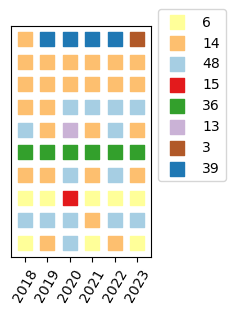

In [12]:
plt = plot_sequences(cluster_sequence[100:110], colors='Paired_r', x_labels=years)
plt.show()

## MARKOV CHAINS

In [13]:
import networkx as nx
from collections import defaultdict

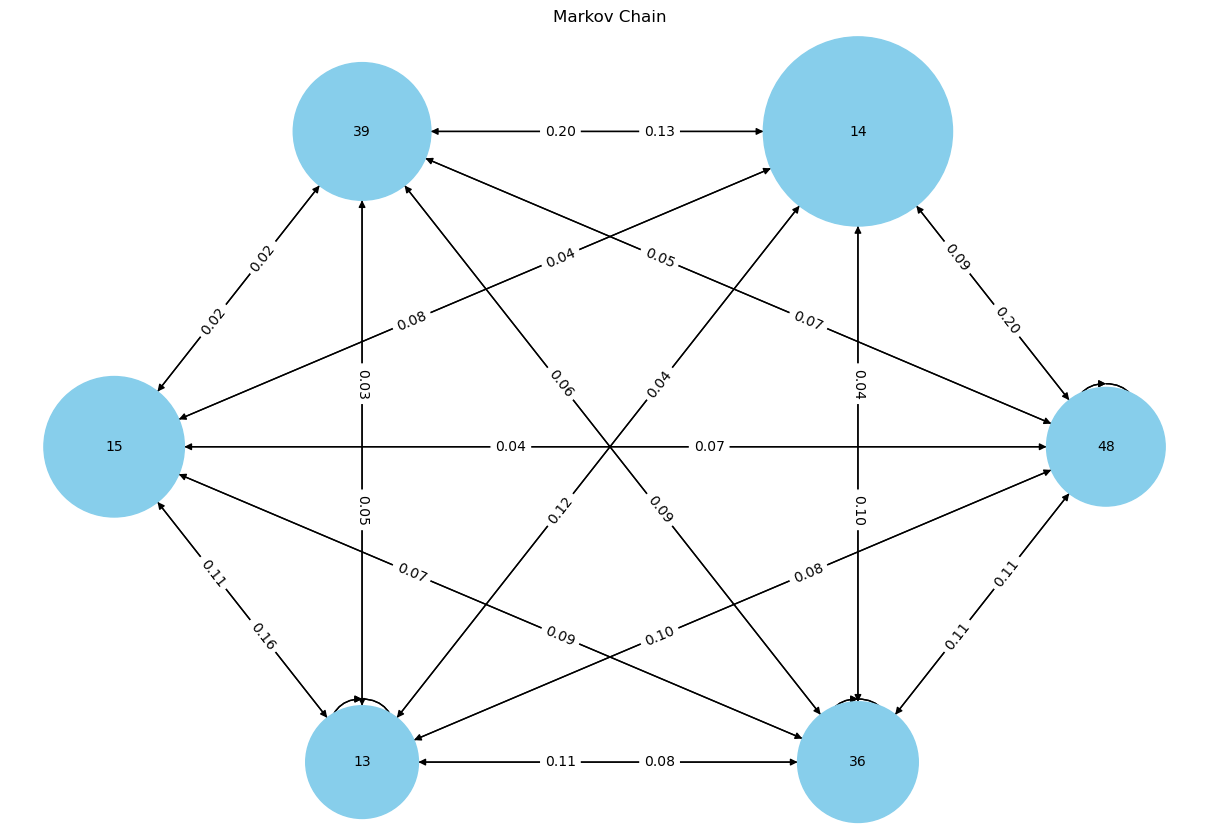

In [107]:
# sequences
sequences = cluster_sequence

# Count transitions
transition_counts = defaultdict(lambda: defaultdict(int))
state_counts = defaultdict(int)
for sequence in sequences:
    for i in range(len(sequence) - 1):
        current_state = sequence[i]
        next_state = sequence[i + 1]
        transition_counts[current_state][next_state] += 1
        state_counts[current_state] += 1
    # Count the last state in the sequence
    state_counts[sequence[-1]] += 1

# Filter out states with fewer than 10 appearances
filtered_states = {state for state, count in state_counts.items() if count >= 500}

# Normalize counts to obtain transition probabilities
transition_matrix = defaultdict(lambda: defaultdict(float))
for state, next_states in transition_counts.items():
    if state in filtered_states:
        total_transitions = sum(next_states[next_state] for next_state in next_states if next_state in filtered_states)
        for next_state, count in next_states.items():
            if next_state in filtered_states:
                transition_matrix[state][next_state] = count / total_transitions

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph, filtering out low probability transitions
for state, next_states in transition_matrix.items():
    for next_state, probability in next_states.items():
        if probability >= 0.01:
            G.add_edge(state, next_state, weight=probability, label=f"{probability:.2f}")

# Combine back-and-forth edge labels
combined_edge_labels = {}
for u, v, data in G.edges(data=True):
    if (v, u) in G.edges:
        combined_label = f"{data['label']} | {G[v][u]['label']}"
        combined_edge_labels[(u, v)] = combined_label
        combined_edge_labels[(v, u)] = combined_label
    else:
        combined_edge_labels[(u, v)] = data['label']

# Calculate node sizes based on state counts
node_sizes = [state_counts[state] * 3 for state in G.nodes()]

# Draw the graph without edges
plt.figure(figsize=(12, 8))  # Increase the figure size
pos = nx.shell_layout(G)  # positions for all nodes, k controls the distance between nodes
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10)

# Draw self-loop edges separately with a different connection style
loop_edges = [(u, v) for u, v in G.edges() if u == v]
nx.draw_networkx_edges(G, pos, edgelist=loop_edges, connectionstyle='arc3,rad=0.5')

# Draw combined edge labels with a slight offset
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.6)

plt.title("Markov Chain")
plt.show()

In [110]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# sequences
sequences = cluster_sequence

# Count transitions
transition_counts = defaultdict(lambda: defaultdict(int))
state_counts = defaultdict(int)
for sequence in sequences:
    for i in range(len(sequence) - 1):
        current_state = sequence[i]
        next_state = sequence[i + 1]
        transition_counts[current_state][next_state] += 1
        state_counts[current_state] += 1
    # Count the last state in the sequence
    state_counts[sequence[-1]] += 1

# Normalize counts to obtain transition probabilities
transition_matrix = defaultdict(lambda: defaultdict(float))
for state, next_states in transition_counts.items():
    total_transitions = sum(next_states.values())
    for next_state, count in next_states.items():
        transition_matrix[state][next_state] = count / total_transitions

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for state, next_states in transition_matrix.items():
    for next_state, probability in next_states.items():
        G.add_edge(state, next_state, weight=probability, label=f"{probability:.2f}")


In [145]:
# Compute communities
communities = nx.community.greedy_modularity_communities(G, weight='weight')

# Convert to list of lists for plotting
communities = [list(community) for community in communities]

In [146]:
communities

[[3, 7, 40, 43, 45, 15, 20, 28, 31],
 [33, 34, 38, 13, 16, 17, 27, 30],
 [32, 2, 36, 8, 44, 23, 24, 29],
 [0, 1, 18, 19, 37, 14],
 [42, 35, 5, 39],
 [48, 49, 10, 47],
 [41, 22, 6],
 [9],
 [12],
 [26],
 [25],
 [46],
 [21],
 [11],
 [4]]

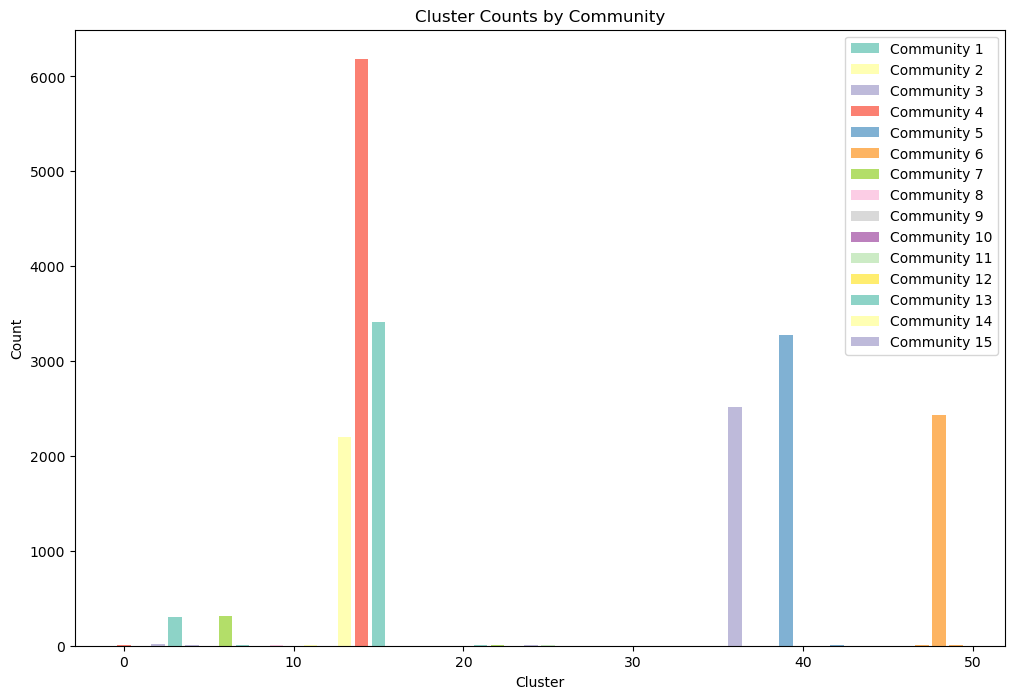

In [144]:
# Plot the cluster counts in a bar chart but color the bars based on the community
plt.figure(figsize=(12, 8))
colors = sns.color_palette('Set3', len(communities))
for i, community in enumerate(communities):
    community_counts = {state: count for state, count in state_counts.items() if state in community}
    plt.bar(community_counts.keys(), community_counts.values(), color=colors[i], label=f"Community {i + 1}")

plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Counts by Community")
plt.legend()
plt.show()

In [134]:
# Since closeness centrality assumes the edge weights are distances, but we have probabilities, we need to convert them
# to distances. We can do this by taking the negative logarithm of the probabilities.
for u, v, data in G.edges(data=True):
    data['distance'] = -np.log(data['weight'])

In [136]:
# Compute closeness centrality
closeness = nx.closeness_centrality(G, distance='distance')

# Sort the closeness values
closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

closeness

[(14, 0.36149491753217877),
 (15, 0.3381261918515652),
 (13, 0.30793807856090893),
 (36, 0.295345309084976),
 (48, 0.2870200542796125),
 (39, 0.25698465001140164),
 (6, 0.1567262664440016),
 (3, 0.15479024337206307),
 (2, 0.09474448273560826),
 (7, 0.08772667554680637),
 (24, 0.08257974156919692),
 (16, 0.08139948396302157),
 (19, 0.08022908883804446),
 (37, 0.08022908883804446),
 (22, 0.07991535444607176),
 (0, 0.07926448762435638),
 (12, 0.07829391784806439),
 (26, 0.07829391784806439),
 (42, 0.0776328538160684),
 (23, 0.07658492886298345),
 (9, 0.07643613344347301),
 (28, 0.07643613344347301),
 (25, 0.07628845235949346),
 (30, 0.07574012203087448),
 (45, 0.07550253009190508),
 (5, 0.07475887823506087),
 (38, 0.07452495102585824),
 (18, 0.07438640954812642),
 (34, 0.07422867451849327),
 (32, 0.07421981912814496),
 (29, 0.07421981912814496),
 (8, 0.07407734555318558),
 (20, 0.07399604561646018),
 (43, 0.07399604561646018),
 (46, 0.07323916216648456),
 (41, 0.0725435057133822),
 (35, 0

## HIDDEN MARKOV MODEL

In [13]:
from SimpleHOHMM import HiddenMarkovModelBuilder as Builder

In [12]:
possible_observations = [str(i) for i in range(0, 50)]
sequences = [[str(i) for i in seq] for seq in cluster_sequence]
possible_states = ['0', '1', '2']

In [26]:
builder = Builder()

In [16]:
builder = Builder()
hmm = builder.build_unsupervised(
    single_states=possible_states,
    all_obs=possible_observations,
    distribution='uniform',
    highest_order=3
)

In [18]:
hmm.learn(sequences, k_smoothing=0.001)

2

In [20]:
hmm.display_parameters()

Starting probabilities (pi):
{'1': 0.3333333333333333, '0': 0.3333333333333333, '2': 0.3333333333333333}
{'1-1': 0.1111111111111111, '1-0': 0.1111111111111111, '1-2': 0.1111111111111111, '0-1': 0.1111111111111111, '0-0': 0.1111111111111111, '0-2': 0.1111111111111111, '2-1': 0.1111111111111111, '2-0': 0.1111111111111111, '2-2': 0.1111111111111111}
{'1-1-1': 0.32554365465757873, '1-1-0': 0.32554365465757873, '1-1-2': 0.32554365465757873, '1-0-1': 0.0009737098344693283, '1-0-0': 0.0009737098344693283, '1-0-2': 0.0009737098344693283, '1-2-1': 0.0009737098344693283, '1-2-0': 0.0009737098344693283, '1-2-2': 0.0009737098344693283, '0-1-1': 0.0009737098344693283, '0-1-0': 0.0009737098344693283, '0-1-2': 0.0009737098344693283, '0-0-1': 0.0009737098344693283, '0-0-0': 0.0009737098344693283, '0-0-2': 0.0009737098344693283, '0-2-1': 0.0009737098344693283, '0-2-0': 0.0009737098344693283, '0-2-2': 0.0009737098344693283, '2-1-1': 0.0009737098344693283, '2-1-0': 0.0009737098344693283, '2-1-2': 0.00097

In [168]:
obs = ['14', '14', '14']
print(hmm.evaluate(obs))
print(hmm.decode(obs))

0.15555535367621995
['1', '1', '0']


## Mapping communities

In [147]:
import cluster_tester
reload(cluster_tester)
from cluster_tester import ClusterTester

In [148]:
tegucigalpa_image = AnalysisImage(presets='Tegucigalpa', year=2023, feature_bands=FEATURES)

img_height = haversine(coords=tegucigalpa_image.get_bounds(side='ceiling'))
img_width = haversine(coords=tegucigalpa_image.get_bounds(side='left'))

x_num_parts, y_num_parts = calc_segment_count(img_height, img_width, 200, 200)

subgeometries = split_geometry(tegucigalpa_image.geometry_sd, x_num_parts=x_num_parts, y_num_parts=y_num_parts)

In [149]:
precario_path = os.path.join("data", "tegucigalpa_PC.zip")
precario_gdf = gpd.read_file(precario_path)

In [166]:
cluster_location_info = tegu_200_eloisa.get_cluster_location_info(year=2023, model=resnet, subgeometries=subgeometries, dissolve_by_cluster=True)

In [167]:
tegu_cluster_tester = ClusterTester(cluster_location_info=cluster_location_info, 
                                    analysis_image=tegucigalpa_image, 
                                    validation_data=precario_gdf, 
                                    cluster_order=communities, 
                                    num_clusters=50,
                                    palette='Paired')

In [168]:
tegu_cluster_tester.plot_clusters()